<a href="https://colab.research.google.com/github/nicolas-pavon/Analitica_colab/blob/master/Entrega%202/Grid_Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analítica de datos - ejemplo de clase lfw_people - comparación distintos métodos de clasificación

## Lectura base de datos y partición conjunto de entrenamiento y conjunto de evaluación

Nota: conjunto de evaluación no se utiliza en NINGUNA etapa de entrenamiento 

Dimensiones base de datos: 
 (1288, 50, 37)
Clases base de datos: 
 ['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Tony Blair']
[[111.666664 125.666664 120.666664 ...  85.666664  80.333336  69.333336]
 [119.333336 134.66667  134.       ...  92.666664  87.333336  72.666664]
 [120.       143.       143.       ...  99.        89.333336  77.      ]
 ...
 [ 69.666664  63.        57.       ... 200.66667  227.       234.      ]
 [ 60.333332  53.333332  47.666668 ... 233.       235.       235.      ]
 [ 56.666668  54.333332  46.333332 ... 233.66667  237.       235.      ]]


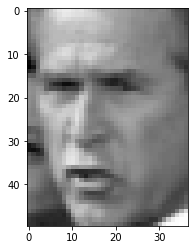

In [0]:
#Paso 1: Lectura
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
#para acceder a archivos desde google drive en google colaboratory
#acceso a google drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
#
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
#
file_id = '1gAYYrq8SzzjytWOzWUE6k9FBffBMxzF0' #copiar nombre nombre del link de compartir despues de ID
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('funciones_people.py') 
from funciones_people import pre_exploratorio, save_fig, plot_confusion_matrix, roc_multiclass, roc_auc_mc
from sklearn.impute import SimpleImputer 
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.pipeline import Pipeline
#base de datos
from sklearn.datasets import fetch_lfw_people
#https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html

%matplotlib inline
#descargar base de datos
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

#ejemplo imagen en base de datos
print('Dimensiones base de datos: \n',lfw_people.images.shape)
plt.imshow(lfw_people.images[30,:,:],cmap='gray')

print('Clases base de datos: \n',lfw_people['target_names'])
print(lfw_people.images[30,:,:])

Dimensiones tipo pandas:  (1288, 1850)


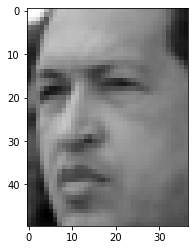

In [0]:
# datos tipo pandas
Xdata = pd.DataFrame(lfw_people.data)
y = lfw_people.target
print('Dimensiones tipo pandas: ',Xdata.shape)
plt.imshow(np.array(Xdata.iloc[0,:]).reshape(lfw_people.images.shape[1],lfw_people.images.shape[2]),cmap='gray')


In [0]:
#Paso 2: Particion entrenamiento y validacion
# Tamaño Xtrain 70%, Tamaño Xtest 30%
Xtrain, Xtest, ytrain,ytest = train_test_split(Xdata,y,test_size=0.3) #fijar en 0.3 para entrenar -- 0.95 para demostrar funcionalidad del código

Xtrain.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1810,1811,1812,1813,1814,1815,1816,1817,1818,1819,1820,1821,1822,1823,1824,1825,1826,1827,1828,1829,1830,1831,1832,1833,1834,1835,1836,1837,1838,1839,1840,1841,1842,1843,1844,1845,1846,1847,1848,1849
46,7.000000,22.666666,110.666664,194.333328,215.666672,210.666672,204.333328,201.666672,200.666672,204.000000,215.333328,219.000000,222.000000,225.333328,227.333328,228.333328,229.000000,230.666672,230.666672,232.666672,233.000000,230.333328,227.0,221.666672,215.000000,211.666672,211.000000,209.333328,206.000000,202.333328,202.333328,198.000000,187.000000,159.666672,124.666664,91.333336,80.333336,9.000000,26.000000,122.000000,...,165.333328,201.666672,221.000000,90.666664,89.666664,84.666664,80.333336,78.000000,76.333336,77.000000,75.666664,68.333336,60.666668,91.666664,132.666672,144.000000,144.333328,142.000000,146.000000,149.666672,153.666672,155.666672,155.000000,155.333328,149.000000,141.000000,138.333328,133.333328,131.333328,136.666672,142.000000,147.333328,146.000000,135.666672,128.666672,132.333328,156.000000,187.333328,217.000000,227.000000
835,80.666664,115.000000,142.333328,167.333328,175.000000,184.666672,195.666672,201.333328,203.333328,199.333328,201.333328,201.666672,203.333328,206.333328,207.666672,206.666672,205.666672,203.333328,203.333328,201.333328,196.333328,193.333328,193.0,192.666672,193.333328,189.333328,179.000000,174.000000,177.333328,180.000000,184.666672,189.666672,178.333328,172.666672,168.333328,164.333328,166.666672,92.000000,132.666672,160.000000,...,113.666664,183.000000,221.666672,76.333336,74.666664,78.333336,82.000000,80.666664,71.333336,56.000000,41.000000,34.000000,29.333334,27.666666,63.000000,148.333328,146.000000,137.000000,130.000000,118.000000,106.666664,102.666664,98.666664,94.666664,97.333336,135.666672,175.000000,177.000000,162.666672,155.000000,160.333328,131.000000,89.333336,87.333336,91.333336,93.333336,112.000000,173.333328,223.666672,228.666672
249,20.333334,39.666668,45.666668,38.000000,26.666666,31.000000,91.333336,135.000000,141.666672,135.000000,132.666672,137.666672,147.666672,154.666672,163.666672,169.666672,169.666672,169.666672,171.666672,179.000000,185.333328,191.666672,201.0,207.000000,208.000000,208.666672,209.666672,205.000000,187.666672,155.666672,110.000000,74.333336,81.000000,93.333336,99.666664,106.333336,104.333336,21.333334,39.333332,41.666668,...,116.333336,125.666664,123.000000,10.666667,12.000000,10.333333,11.000000,23.333334,41.333332,38.333332,28.000000,25.666666,12.000000,6.666667,15.666667,25.000000,29.666666,34.333332,36.666668,37.666668,42.666668,44.666668,47.000000,52.333332,57.333332,55.333332,49.333332,46.666668,46.333332,52.000000,62.333332,71.333336,80.000000,82.000000,90.666664,104.333336,123.000000,136.000000,135.333328,127.333336
1181,68.333336,61.333332,86.666664,117.000000,132.000000,136.000000,141.333328,145.333328,150.333328,158.000000,159.666672,163.333328,170.000000,173.000000,178.333328,184.000000,188.000000,189.333328,192.000000,190.000000,188.000000,187.666672,184.0,180.000000,173.000000,162.666672,149.333328,119.666664,96.333336,101.333336,80.666664,59.666668,49.000000,46.333332,44.666668,42.000000,36.666668,52.333332,69.000000,105.666664,...,62.666668,62.333332,62.000000,128.666672,121.333336,65.666664,50.000000,54.000000,48.666668,40.666668,32.333332,32.333332,37.333332,47.666668,54.666668,54.333332,53.000000,55.666668,62.666668,79.666664,98.000000,108.000000,111.000000,110.666664,121.666664,133.666672,133.333328,125.000000,121.666664,108.000000,79.333336,45.000000,36.666668,36.000000,36.333332,34.000000,33.333332,34.333332,35.666668,35.000000
837,6.666667,7.666667,11.000000,14.666667,41.333332,82.333336,138.333328,188.333328,223.333328,231.333328,232.333328,233.666672,234.333328,233.333328,229.333328,230.333328,229.333328,228.333328,225.666672,225.000000,220.000000,221.333328,224.0,233.666672,244.000000,245.333328,246.0

[t-SNE] Computing 70 nearest neighbors...
[t-SNE] Indexed 901 samples in 0.041s...
[t-SNE] Computed neighbors for 901 samples in 2.929s...
[t-SNE] Computed conditional probabilities for sample 901 / 901
[t-SNE] Mean sigma: 14.863049
[t-SNE] Computed conditional probabilities in 0.048s
[t-SNE] Iteration 50: error = 74.6468506, gradient norm = 0.3603278 (50 iterations in 0.393s)
[t-SNE] Iteration 100: error = 75.3478699, gradient norm = 0.3247456 (50 iterations in 0.370s)
[t-SNE] Iteration 150: error = 75.2009811, gradient norm = 0.3145069 (50 iterations in 0.372s)
[t-SNE] Iteration 200: error = 75.0043259, gradient norm = 0.3222679 (50 iterations in 0.419s)
[t-SNE] Iteration 250: error = 74.0422821, gradient norm = 0.3481054 (50 iterations in 0.412s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.042282
[t-SNE] KL divergence after 251 iterations: 1797693134862315708145274237317043567980705675258449965989174768031572607800285387605895586327668781715404589535143824

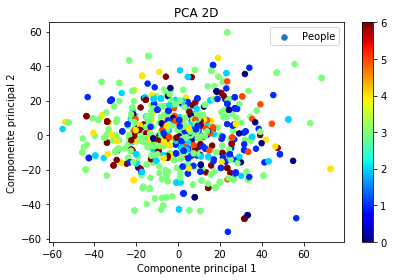

Guardando... relevancia_PCA_eigenface


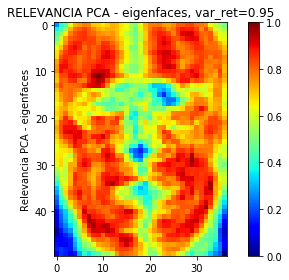

Guardando... tsne_2D


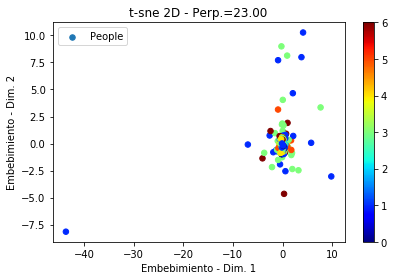

True

In [0]:
#%% Paso 3 : Analisis exploratorio
#preproceso entrada  y salida para analisis exploratorio
img_path = ''
pre_exploratorio(Xtrain,ytrain,img_path,'People',lfw_people.images.shape[1],lfw_people.images.shape[2])

In [0]:
#%% Paso 4 : Escoger modelo por gridsearchCV utilizando pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, SGDClassifier, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.externals import joblib #https://joblib.readthedocs.io/en/latest/

steps=[[('rep',  PCA()),
        ('cla', LogisticRegression())],
       [('rep',  PCA()),
        ('cla', SGDClassifier())],
       [('rep',  PCA()),
        ('cla', SVC())],
       [('rep', PCA()),
        ('cla', RandomForestClassifier())],
       [('rep', PCA()),
        ('cla', KNeighborsClassifier())],
       [('cla', LogisticRegression())],
       [('cla', SGDClassifier())],
       [('cla', SVC())],
       [('cla', RandomForestClassifier())],
       [('cla', KNeighborsClassifier())]
      ]
parameters = [{
              'rep__n_components' : [0.8,0.9],              
              'cla__C': [0.5,1],
              },
              {
              'rep__n_components' : [0.8,0.9],              
              'cla__alpha': [0.0001,0.001],
              },
              {
             'rep__n_components' : [0.8,0.9],              
             'cla__C': [0.1,1,100,500,1e3],
             'cla__gamma': [0.01, 0.1, 1,10, 100,1e3],    
              },
              {
             'rep__n_components' : [0.8,0.9],              
             'cla__max_depth': [8,10,12],   
             'cla__n_estimators' : [10,20,40,100],
              },
              {
              'rep__n_components' : [0.8,0.9],
              'cla__n_neighbors' : [3,5],
              },
              {              
              'cla__C': [0.5,1],
              },
              {              
              'cla__alpha': [0.0001,0.001],
              },
              {             
             'cla__C': [0.1,1,100,500,1e3],
             'cla__gamma': [0.01, 0.1, 1,10, 100,1e3],    
              },
              {
             'cla__max_depth': [8,10,12],   
             'cla__n_estimators' : [10,20,40,100], 
              },
              {
              'cla__n_neighbors' : [3,5]
              }
             ]

label_models = ['PCA_Logistic','PCA_SGD', 'PCA_SVC','PCA_Forest','PCA_KNN','Logistic','SGD','SVC','Forest','KNN']

best_model = []
filename = '' #resultados/people_comp
for i in range(len(steps)):
    print('modelo %d/%d' % (i+1,len(steps)))
    grid_search = GridSearchCV(Pipeline(steps[i]), parameters[i], n_jobs=-1,cv=5,
                                scoring='balanced_accuracy',verbose=10)
    grid_search.fit(Xtrain, ytrain)
    #print(grid_search.cv_results_)
    #mejor modelo entrenado
    best_model += [grid_search.best_estimator_]
    joblib.dump(best_model,filename+".pkl")

print('Mejores modelos:\n')
best_model

modelo 1/10
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   19.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   19.7s finished


modelo 2/10
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   12.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   12.8s finished


modelo 3/10
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   35.4s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   41.9s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   49.5s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   57.3s
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  1

modelo 4/10
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   36.5s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   52.8s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.3min finished


modelo 5/10
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   12.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   12.2s finished


modelo 6/10
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   31.0s finished


modelo 7/10
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    5.5s finished


modelo 8/10
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   54.3s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  4

modelo 9/10
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   32.7s finished


modelo 10/10
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    5.2s finished


Mejores modelos:



[Pipeline(memory=None,
          steps=[('rep',
                  PCA(copy=True, iterated_power='auto', n_components=0.9,
                      random_state=None, svd_solver='auto', tol=0.0,
                      whiten=False)),
                 ('cla',
                  LogisticRegression(C=0.5, class_weight=None, dual=False,
                                     fit_intercept=True, intercept_scaling=1,
                                     l1_ratio=None, max_iter=100,
                                     multi_class='warn', n_jobs=None,
                                     penalty='l2', random_state=None,
                                     solver='warn', tol=0.0001, verbose=0,
                                     warm_start=False))],
          verbose=False), Pipeline(memory=None,
          steps=[('rep',
                  PCA(copy=True, iterated_power='auto', n_components=0.9,
                      random_state=None, svd_solver='auto', tol=0.0,
                      whiten=False)),


# Calcular rendimiento en cojunto de test

Evaluando modelo 1/10
Guardando... PCA_Logistic


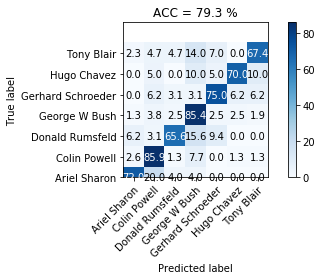

                   precision    recall  f1-score   support

     Ariel Sharon       0.72      0.72      0.72        25
     Colin Powell       0.80      0.86      0.83        78
  Donald Rumsfeld       0.70      0.66      0.68        32
    George W Bush       0.86      0.85      0.86       157
Gerhard Schroeder       0.69      0.75      0.72        32
      Hugo Chavez       0.67      0.70      0.68        20
       Tony Blair       0.78      0.67      0.72        43

         accuracy                           0.79       387
        macro avg       0.75      0.74      0.74       387
     weighted avg       0.79      0.79      0.79       387

Evaluando modelo 2/10
Guardando... PCA_SGD


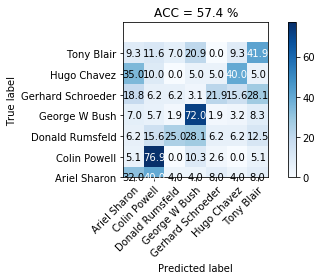

                   precision    recall  f1-score   support

     Ariel Sharon       0.19      0.32      0.24        25
     Colin Powell       0.65      0.77      0.70        78
  Donald Rumsfeld       0.47      0.25      0.33        32
    George W Bush       0.80      0.72      0.76       157
Gerhard Schroeder       0.41      0.22      0.29        32
      Hugo Chavez       0.32      0.40      0.36        20
       Tony Blair       0.35      0.42      0.38        43

         accuracy                           0.57       387
        macro avg       0.46      0.44      0.44       387
     weighted avg       0.59      0.57      0.58       387

Evaluando modelo 3/10
Guardando... PCA_SVC


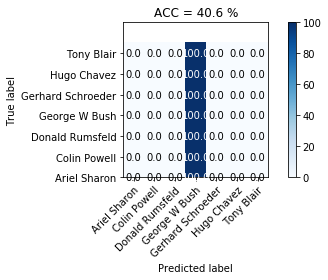

                   precision    recall  f1-score   support

     Ariel Sharon       0.00      0.00      0.00        25
     Colin Powell       0.00      0.00      0.00        78
  Donald Rumsfeld       0.00      0.00      0.00        32
    George W Bush       0.41      1.00      0.58       157
Gerhard Schroeder       0.00      0.00      0.00        32
      Hugo Chavez       0.00      0.00      0.00        20
       Tony Blair       0.00      0.00      0.00        43

         accuracy                           0.41       387
        macro avg       0.06      0.14      0.08       387
     weighted avg       0.16      0.41      0.23       387

Evaluando modelo 4/10
Guardando... PCA_Forest


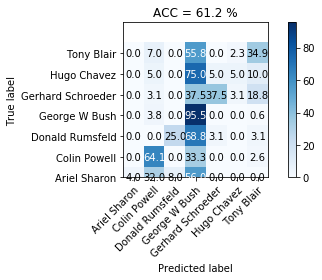

                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.04      0.08        25
     Colin Powell       0.72      0.64      0.68        78
  Donald Rumsfeld       0.80      0.25      0.38        32
    George W Bush       0.57      0.96      0.71       157
Gerhard Schroeder       0.86      0.38      0.52        32
      Hugo Chavez       0.33      0.05      0.09        20
       Tony Blair       0.56      0.35      0.43        43

         accuracy                           0.61       387
        macro avg       0.69      0.38      0.41       387
     weighted avg       0.66      0.61      0.56       387

Evaluando modelo 5/10
Guardando... PCA_KNN


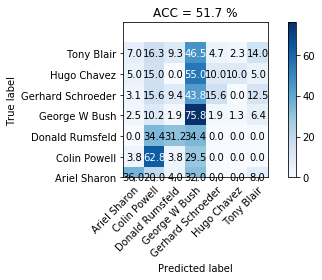

                   precision    recall  f1-score   support

     Ariel Sharon       0.43      0.36      0.39        25
     Colin Powell       0.51      0.63      0.56        78
  Donald Rumsfeld       0.42      0.31      0.36        32
    George W Bush       0.58      0.76      0.66       157
Gerhard Schroeder       0.42      0.16      0.23        32
      Hugo Chavez       0.40      0.10      0.16        20
       Tony Blair       0.26      0.14      0.18        43

         accuracy                           0.52       387
        macro avg       0.43      0.35      0.36       387
     weighted avg       0.48      0.52      0.48       387

Evaluando modelo 6/10
Guardando... Logistic


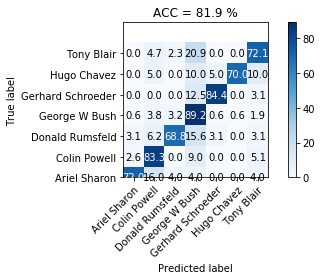

                   precision    recall  f1-score   support

     Ariel Sharon       0.82      0.72      0.77        25
     Colin Powell       0.81      0.83      0.82        78
  Donald Rumsfeld       0.76      0.69      0.72        32
    George W Bush       0.83      0.89      0.86       157
Gerhard Schroeder       0.90      0.84      0.87        32
      Hugo Chavez       0.93      0.70      0.80        20
       Tony Blair       0.72      0.72      0.72        43

         accuracy                           0.82       387
        macro avg       0.83      0.77      0.79       387
     weighted avg       0.82      0.82      0.82       387

Evaluando modelo 7/10
Guardando... SGD


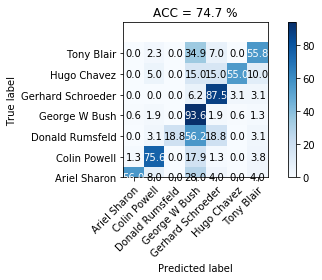

                   precision    recall  f1-score   support

     Ariel Sharon       0.88      0.56      0.68        25
     Colin Powell       0.88      0.76      0.81        78
  Donald Rumsfeld       1.00      0.19      0.32        32
    George W Bush       0.71      0.94      0.81       157
Gerhard Schroeder       0.62      0.88      0.73        32
      Hugo Chavez       0.85      0.55      0.67        20
       Tony Blair       0.71      0.56      0.62        43

         accuracy                           0.75       387
        macro avg       0.81      0.63      0.66       387
     weighted avg       0.78      0.75      0.73       387

Evaluando modelo 8/10
Guardando... SVC


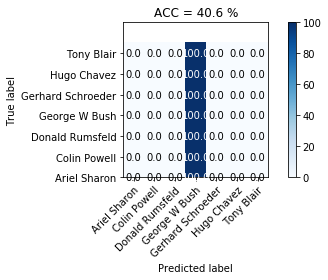

                   precision    recall  f1-score   support

     Ariel Sharon       0.00      0.00      0.00        25
     Colin Powell       0.00      0.00      0.00        78
  Donald Rumsfeld       0.00      0.00      0.00        32
    George W Bush       0.41      1.00      0.58       157
Gerhard Schroeder       0.00      0.00      0.00        32
      Hugo Chavez       0.00      0.00      0.00        20
       Tony Blair       0.00      0.00      0.00        43

         accuracy                           0.41       387
        macro avg       0.06      0.14      0.08       387
     weighted avg       0.16      0.41      0.23       387

Evaluando modelo 9/10
Guardando... Forest


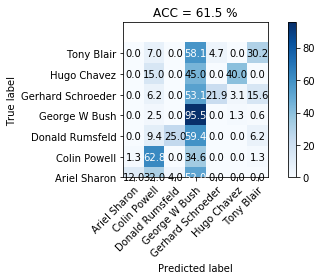

                   precision    recall  f1-score   support

     Ariel Sharon       0.75      0.12      0.21        25
     Colin Powell       0.68      0.63      0.65        78
  Donald Rumsfeld       0.89      0.25      0.39        32
    George W Bush       0.58      0.96      0.72       157
Gerhard Schroeder       0.78      0.22      0.34        32
      Hugo Chavez       0.73      0.40      0.52        20
       Tony Blair       0.59      0.30      0.40        43

         accuracy                           0.61       387
        macro avg       0.71      0.41      0.46       387
     weighted avg       0.66      0.61      0.57       387

Evaluando modelo 10/10
Guardando... KNN


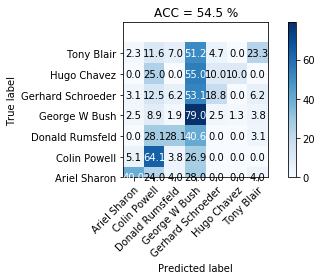

                   precision    recall  f1-score   support

     Ariel Sharon       0.50      0.40      0.44        25
     Colin Powell       0.54      0.64      0.58        78
  Donald Rumsfeld       0.43      0.28      0.34        32
    George W Bush       0.58      0.79      0.67       157
Gerhard Schroeder       0.43      0.19      0.26        32
      Hugo Chavez       0.50      0.10      0.17        20
       Tony Blair       0.50      0.23      0.32        43

         accuracy                           0.55       387
        macro avg       0.50      0.38      0.40       387
     weighted avg       0.53      0.55      0.51       387



In [0]:
#%% Paso 5: evaluar sobre Xtest
my_model_loaded = joblib.load(filename+".pkl")
path_img = '' #im2/
for i in range(len(my_model_loaded)):
    print('Evaluando modelo %d/%d' % (i+1,len(my_model_loaded)))

    ytest_e = my_model_loaded[i].predict(Xtest)
    acc = accuracy_score(ytest,ytest_e)
     
    plot_confusion_matrix(
                          ytest, ytest_e, 
                          classes=lfw_people.target_names,
                          normalize=True,
                          title='ACC = %.1f %%' % (100*acc)
                          )
    plt.ylim([0,len(lfw_people.target_names)+0.5])
    save_fig(path_img,label_models[i])                      
    plt.show()
    
    cr = classification_report(
                               ytest, ytest_e, 
                               labels=range(lfw_people.target_names.shape[0]),
                               target_names=lfw_people.target_names
                               )                          
    #support = #muestras en la clase estudiada
    print(cr)


## Curva ROC multiclase - sobre conjunto de test

Evaluando ROC modelo 1/10
Guardando... ROC curve PCA_Logistic


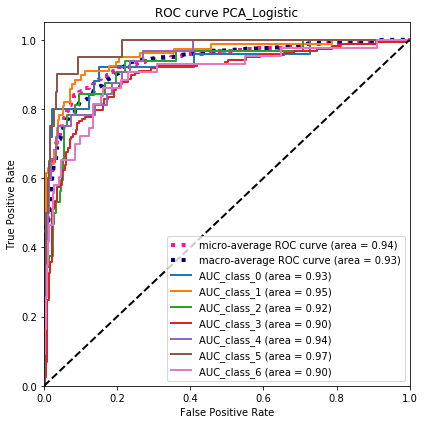

Evaluando ROC modelo 2/10
Guardando... ROC curve PCA_SGD


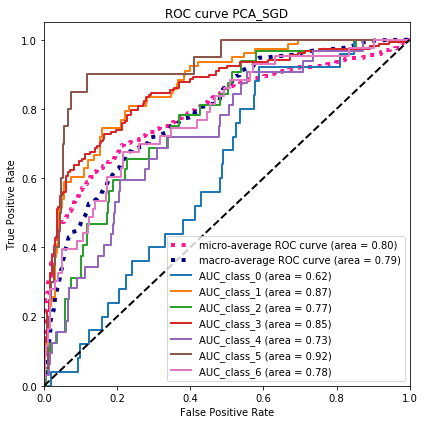

Evaluando ROC modelo 3/10
Guardando... ROC curve PCA_SVC


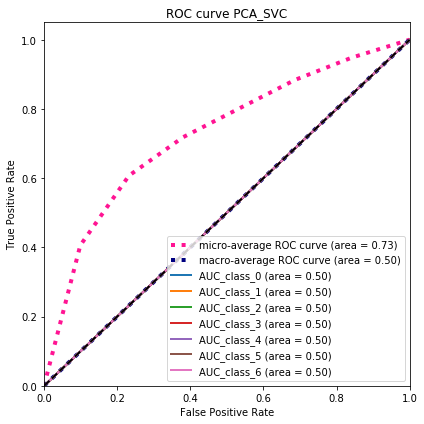

Evaluando ROC modelo 4/10


AttributeError: ignored

In [0]:
from sklearn.preprocessing import label_binarize

ytrain_b = label_binarize(ytrain, classes=range(lfw_people.target_names.shape[0]))
ytest_b = label_binarize(ytest, classes=range(lfw_people.target_names.shape[0]))

for i in range(len(my_model_loaded)):
    print('Evaluando ROC modelo %d/%d' % (i+1,len(my_model_loaded)))
    ytest_score = my_model_loaded[i].decision_function(Xtest) #debe calcularse la funcion de decision o el posterior de la probabilidad
    roc_auc, fpr, tpr, n_classes = roc_multiclass(ytest_b,ytest_score)
    roc_auc_mc(roc_auc,fpr,tpr,n_classes,'ROC curve ' + label_models[i],path_img)
    